# Classification of Target Position based on Scaler values
### *A brief, exploratory study*

by: Bryan Dannowitz

### Problem:
For a certain range of data, we have possibly inaccurate labels on our target position. We wish to verify their accuracy by any means possible. We have many sets of well-labelled test sets of data to draw on to see if we are able to.

### Objective:
Chuck Brown suggests that a careful inspection of the values in the Scaler table should allow us to differentiate between the different targets. Without any *a priori* knowledge of the meaning of these values, we wish to take well-labelled data and see if any of the values can provide a clear distinction between target positions.

### Procedure:
1. Get scaler data from MySQL db as a set of *features*
2. Clean it up by removing entries from 'bad spills'
3. Exclude any non-helpful *features*
4. For each type of value, plot the distributions for each target position.
5. See if any given scaler distinguishes between two or more target positions (eye check for now).
6. Look at our not-well-labelled data and see if it shares similar features.

In [1]:
import MySQLdb as mdb               # Raw data source is MySQL
import sys                          # For importing my own modules
import matplotlib.pyplot as plt     # For plotting some distributions
import seaborn as sns               # For violin plotting, etc.
import pandas as pd                 # Workhorse data management tool
import numpy as np                  # For matrices, arrays, nan's
import math

# My own modules here
sys.path.append('../modules')       # Include location of my own modules
from spill import get_bad_spills    # Function for getting a set (python-wise) of bad spillID's
from servers import server_dict     # Contains specific connection parameters to our servers

# To view plots inline
%matplotlib inline                  

### First, we read our scaler values into a data frame
* No NULL values
* For scalers, use End-of-Spill (EOS) readout only
* Keep track of the target position (targetPos)

In [1]:
# Define our source MySQL server host name and schema
server = 'e906-db3.fnal.gov'
schema = 'merged_roadset62_R004_V005'
analysis_schema = 'user_dannowitz_target_analysis'
analysis_table = 'target_analysis'

In [2]:
create_query = """
               CREATE TABLE IF NOT EXISTS %s.%s
               (
                   spillID MEDIUMINT NOT NULL,
                   name VARCHAR(64),
                   value DOUBLE NOT NULL,
                   targetPos INT NOT NULL
                )"""

In [19]:
# Here is our MySQL query that will grab all the data we want
#     Most of this requires a bit of domain expertise to understand
#     as it's specific to our experiment's data structure
scaler_query =  """
                INSERT INTO %s.%s
                ### Get data from our Scaler table, along with the target position.
                ### This contains features from our triggering systems (data taking rates)
                
                SELECT s.spillID, scalerName AS `name`, value, targetPos
                FROM Scaler 
                INNER JOIN Spill s              # Source of targetPos
                    USING(spillID) 
                WHERE scalerName IS NOT NULL AND 
                      s.spillID NOT BETWEEN 416709 AND 423255 AND
                      s.spillID NOT BETWEEN 482574 AND 484924 AND
                      spillType='EOS'
                """

In [20]:
beam_query = """
             INSERT INTO %s.%s
             ### Get data from our Beam table, along with the target position
             ### This contains features from our proton beam and radiation monitors

             SELECT s.spillID, name, value, targetPos 
             FROM Beam
             INNER JOIN Spill s              # Source of targetPos
                 USING(spillID)
             WHERE name IS NOT NULL AND
                 LEFT(name,3)!='F:M' AND   # Exclude features that are always NULL
                 name!='F:NM2SEM' AND      # 
                 name!='U:TODB25' AND      #
                 name!='S:KTEVTC' AND      #
                 s.spillID NOT BETWEEN 416709 AND 423255 AND
                 s.spillID NOT BETWEEN 482574 AND 484924
            """

In [21]:
fetch_query = """SELECT * FROM %s.%s"""

In [27]:
# Run the query and read the resultset into a DataFrame
try:
    db = mdb.connect(read_default_file='../.my.cnf',       # Keep my login credentials secure
                     read_default_group='guest',           # Read-only access to important data
                     host=server,
                     db=schema,
                     port=server_dict[server]['port'])
    
    cur = db.cursor()
    
    cur.execute("SHOW DATABASES LIKE '%s'" % analysis_schema)      # See if schema exists
    if cur.rowcount != 0:
        cur.execute("DROP DATABASE %s" % analysis_schema)          # Drop if it does
    cur.execute("CREATE DATABASE %s" % analysis_schema)            
    cur.execute(create_query % (analysis_schema, analysis_table))
    cur.execute(scaler_query % (analysis_schema, analysis_table))
    cur.execute(beam_query % (analysis_schema, analysis_table))
    
    scaler_df = pd.read_sql(fetch_query % (analysis_schema, analysis_table), db)

    if db:
        db.close()

except mdb.Error, e:                                       # Always catch exceptions with MySQL

    print "Error %d: %s" % (e.args[0], e.args[1])

1
2
3
4
5


In [28]:
scaler_df.to_csv('insight_demo_roadset62.csv')

In [7]:
# ...and investigate data types.
# We will want the 'value' field to be 'float' type
scaler_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 905513 entries, 0 to 905512
Data columns (total 4 columns):
spillID      905513 non-null int64
name         905513 non-null object
value        905513 non-null object
targetPos    905513 non-null int64
dtypes: int64(2), object(2)

In [8]:
# Cast as float
scaler_df[['value']] = scaler_df[['value']].astype(float)
scaler_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 905513 entries, 0 to 905512
Data columns (total 4 columns):
spillID      905513 non-null int64
name         905513 non-null object
value        905513 non-null float64
targetPos    905513 non-null int64
dtypes: float64(1), int64(2), object(1)

### Clean up this data by removing entries that correspond to *Bad Spills*
There are several criteria by which we classify a 5-second spill of data to be un-analyzable or irregular. Let's exclude those.

In [11]:
try:
    # See if this has already been populated
    bad_spill_set
except:
    # Get the set of bad (non-sense) spills for this data
    bad_spill_set = get_bad_spills(server, schema)
    
# Get rid of entries that correspond to bad spills
scaler_df = scaler_df.query('spillID not in bad_spill_set')

In [13]:
# How many features are we working with here?
value_names = scaler_df.name.unique()
print len(value_names), "unique features"

89 unique features


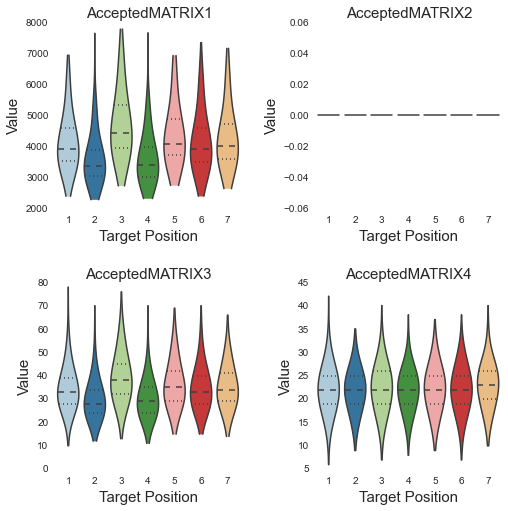

In [30]:
# Look at the first few
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
index = 0
for value_name in value_names[:4]:
    subset_df = scaler_df[(scaler_df.name == value_name)]
    axis = axes[math.floor(index/2),index%2]
    sns.violinplot(subset_df.value, 
                   subset_df.targetPos, 
                   color="Paired", 
                   bw=0.7,
                   ax=axis)
    axis.set_title(value_name, fontsize=15)
    axis.set_xlabel('Target Position', fontsize=15)
    axis.set_ylabel('Value', fontsize=15)
    index = index + 1
    
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

### Now, we see there are some variables that are always just zero, and this isn't helpful

1. Pivot the dataframe 
2. Inspect the distributions to identify the 'always-zero' scalerName values
3. Remove them from our pivoted dataframe and our scaler_df dataset

In [31]:
# We want to see our scalerNames as column indexes
pivoted = scaler_df.pivot('spillID', 'name', 'value'); pivoted.head()

name     AcceptedBOS  AcceptedEOS  AcceptedMATRIX1  AcceptedMATRIX2  \
spillID                                                               
370239             0            1             4535                0   
370240             0            1             3475                0   
370241             0            1             4887                0   
370242             0            1             5278                0   
370243             0            1             5066                0   

name     AcceptedMATRIX3  AcceptedMATRIX4  AcceptedMATRIX5  AcceptedNIM1  \
spillID                                                                    
370239                44               30               29            47   
370240                30               19               21            42   
370241                40               27               22            51   
370242                37               30               28            46   
370243                42               30               23            45   

name     AcceptedNIM2  AcceptedNIM3  AcceptedNIM4  AcceptedNIM5  \
spillID                                                           
370239              0            16             0             0   
370240              0            16             0             0   
370241              0            15             0             0   
370242              0            11             0             0   
370243              0            18             0             0   

name     AfterInhMATRIX1  AfterInhMATRIX2  AfterInhMATRIX3  AfterInhMATRIX4  \
spillID                                                                       
370239             10252           248696            10652          1150180   
370240              6388           195771             6522           884948   
370241             13116           463265            13599          1171731   
370242             13786           405583            14237          1199214   
370243             13237           357095            13768          1221472   

name     AfterInhMATRIX5  AfterInhNIM1  AfterInhNIM2  E:M2C2HF      
spillID                                                             
370239            108362       1867852        452984  0.571946 ...  
370240             77742       1741208        420440  0.573434 ...  
370241            121871       1857601        478681  0.552720 ...  
370242            127134       1913108        522911  0.551332 ...  
370243            125990       1952682        510225  0.545397 ...  

[5 rows x 89 columns]

In [32]:
# Replace sentinel values with NaN's and then drop those rows
pivoted = pivoted.replace(-9999,np.nan).dropna(axis=0,how='any')

In [33]:
# We take a peek to see what the values in each look like overall
pivoted.describe()

name,AcceptedBOS,AcceptedEOS,AcceptedMATRIX1,AcceptedMATRIX2,AcceptedMATRIX3,AcceptedMATRIX4,AcceptedMATRIX5,AcceptedNIM1,AcceptedNIM2,AcceptedNIM3,AcceptedNIM4,AcceptedNIM5,AfterInhMATRIX1,AfterInhMATRIX2,AfterInhMATRIX3,AfterInhMATRIX4,AfterInhMATRIX5,AfterInhNIM1,AfterInhNIM2,E:M2C2HF,
count,8379,8379,8379.000000,8379,8379.000000,8379.000000,8379.000000,8379.000000,8379,8379.000000,8379,8379,8379.000000,8379.000000,8379.000000,8379.000000,8379.000000,8379.000000,8379.000000,8379.000000,...
mean,0,1,4207.386681,0,35.010264,22.136293,19.863946,40.451605,0,15.124478,0,0,11038.188686,364859.216852,11283.310658,1028080.093448,102018.089271,1856482.317341,569292.900107,0.567025,...
std,0,0,983.457917,0,9.396857,4.560832,5.160620,4.883009,0,1.937960,0,0,3017.358742,146634.538461,3091.114047,129383.136403,20213.113718,117852.793043,95222.695618,0.053421,...
min,0,1,2281.000000,0,12.000000,8.000000,5.000000,21.000000,0,7.000000,0,0,4424.000000,102186.000000,4366.000000,678475.000000,58916.000000,1319894.000000,335160.000000,0.485984,...
25%,0,1,3515.000000,0,28.000000,19.000000,16.000000,37.000000,0,14.000000,0,0,8940.000000,261979.500000,9136.500000,939137.500000,89130.500000,1776475.000000,494158.500000,0.551347,...
50%,0,1,3991.000000,0,34.000000,22.000000,20.000000,41.000000,0,15.000000,0,0,10511.000000,339106.000000,10757.000000,1013676.000000,99813.000000,1851160.000000,565664.000000,0.562292,...
75%,0,1,4725.500000,0,40.000000,25.000000,23.000000,44.000000,0,16.000000,0,0,12802.000000,432536.000000,13095.500000,1109031.500000,112803.500000,1941813.000000,638860.500000,0.574834,...
max,0,1,7783.000000,0,76.000000,40.000000,73.000000,58.000000,0,20.000000,0,0,29266.000000,1918262.000000,29596.000000,1596577.000000,398270.000000,2425823.000000,887760.000000,1.535497,...


In [37]:
# It's sufficient to say that if the standard deviation is 0, then it's certainly not useful
zero_std_series = (pivoted.describe().ix['std'] == 0)
# Get an array of all the features with zero standard deviations
zero_std_features = zero_std_series[zero_std_series == True].index.values; zero_std_features

array(['AcceptedBOS', 'AcceptedEOS', 'AcceptedMATRIX2', 'AcceptedNIM2',
       'AcceptedNIM4', 'AcceptedNIM5', 'E:M3TGHF', 'E:M3TGHI', 'E:M3TGVF',
       'E:M3TGVI', 'G:BNCH13', 'G:NBSYD', 'NM3ION', 'PrescaleMATRIX2',
       'PrescaleNIM2', 'PrescaleNIM4', 'PrescaleNIM5', 'PrescaledBOS',
       'PrescaledEOS'], dtype=object)

In [39]:
# Get rid of these features
_ = pivoted.drop(zero_std_features, axis=1, inplace=True)

In [40]:
# Now that you have your features, let's prepare the lables, or, our target positions
targpos_df = scaler_df[['spillID','targetPos']].drop_duplicates().sort('spillID')
targpos_df.head()

,spillID,targetPos
363308,370239,5
363352,370240,4
363396,370241,3
363440,370242,3
363484,370243,3


In [41]:
# And here is our full data set in all its glory
# 89 features, no NaN's, and no completely meaningless features (std dev != 0)
full_df = pd.merge(pivoted, targpos_df, how='left', right_on='spillID', left_index=True)

In [59]:
full_df = full_df.drop('Unnamed: 0', axis=1).set_index('spillID')
full_df.head()

AcceptedMATRIX1  AcceptedMATRIX3  AcceptedMATRIX4  AcceptedMATRIX5  \
spillID                                                                       
370239              4535               44               30               29   
370240              3475               30               19               21   
370241              4887               40               27               22   
370242              5278               37               30               28   
370243              5066               42               30               23   

         AcceptedNIM1  AcceptedNIM3  AfterInhMATRIX1  AfterInhMATRIX2  \
spillID                                                                 
370239             47            16            10252           248696   
370240             42            16             6388           195771   
370241             51            15            13116           463265   
370242             46            11            13786           405583   
370243             45            18            13237           357095   

         AfterInhMATRIX3  AfterInhMATRIX4  AfterInhMATRIX5  AfterInhNIM1  \
spillID                                                                    
370239             10652          1150180           108362       1867852   
370240              6522           884948            77742       1741208   
370241             13599          1171731           121871       1857601   
370242             14237          1199214           127134       1913108   
370243             13768          1221472           125990       1952682   

         AfterInhNIM2  E:M2C2HF  E:M2C2HI  E:M2C2HM   E:M2C2HS  E:M2C2VF  \
spillID                                                                    
370239         452984  0.571946     24901 -0.301292  13.714303  0.605016   
370240         420440  0.573434     25201 -0.233265  13.712535  0.599452   
370241         478681  0.552720     27120 -0.255346  13.670285  0.564557   
370242         522911  0.551332     29977 -0.257547  13.690655  0.561861   
370243         510225  0.545397     28514 -0.239988  13.669893  0.557419   

         E:M2C2VI  E:M2C2VM      
spillID                          
370239    23733.0 -0.398539 ...  
370240    23843.0 -0.474459 ...  
370241    26146.5 -0.528761 ...  
370242    28908.0 -0.460461 ...  
370243    27544.5 -0.468559 ...  

[5 rows x 71 columns]

In [60]:
# Write it to file for use in the next part.
full_df.to_csv('insight_demo.csv')

# Create a Random Forest From Freshly-Wrangled Data

In [66]:
from sklearn.ensemble import RandomForestClassifier    
from sklearn import cross_validation                   # We'll want to cross-validate our RF

In [63]:
# If the data is already written, and we're re-visiting, 
#    just load the prepared data here!
full_df = pd.read_csv('insight_demo.csv', index_col='spillID')

In [68]:
# Split the DataFrame up into 'data' and 'labels'
labels = full_df[['targetPos']].values
data = full_df.drop('targetPos', axis=1).values

In [69]:
d_train, d_test, l_train, l_test \
    = cross_validation.train_test_split(data, labels, test_size=0.25, random_state=2)

In [80]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='sqrt',
                             min_samples_split=1, random_state=2)

rfc.fit(d_train, np.ravel(l_train))

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='sqrt',
            min_density=None, min_samples_leaf=1, min_samples_split=1,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=2,
            verbose=0)

In [81]:
result = rfc.predict(d_test)

print("RF prediction accuracy = {0:5.1f}%".format(100.0 * rfc.score(d_test, l_test)))

RF prediction accuracy =  80.2%


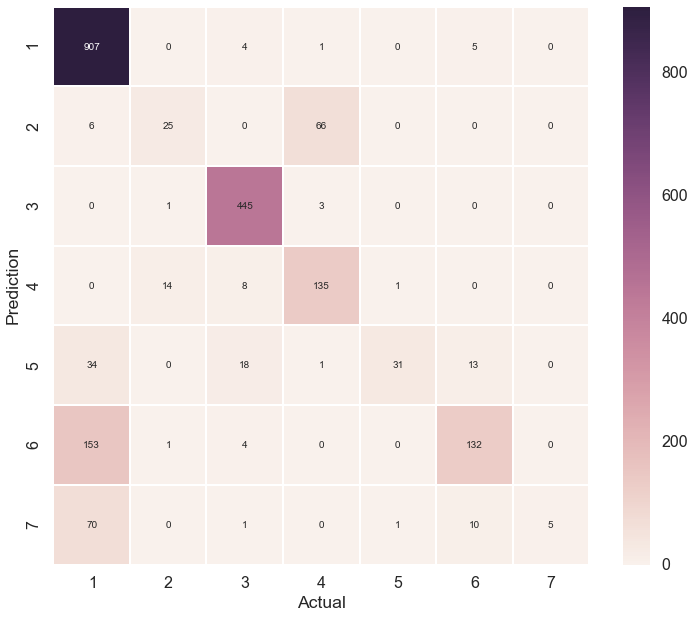

In [96]:
sns.set_context("poster")
plt.figure(figsize=(12, 10))

# Define names for the target positions
names = ['1','2','3','4','5','6','7']

# Make a 2D histogram from the test and result arrays
pts, xe, ye = np.histogram2d(np.ravel(l_test), result, bins=7)

# For simplicity we create a new DataFrame
pd_pts = pd.DataFrame(pts.astype(int), index=names, columns=names )
    
# Display heatmap and add decorations
hm = sns.heatmap(pd_pts, annot=True, fmt="d")

plt.xlabel("Actual")
plt.ylabel("Prediction")